In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import math
import time
from torch.utils.data import DataLoader, Dataset
from time import sleep
from tqdm import tqdm
import numpy as np
from fastprogress.fastprogress import master_bar, progress_bar
from torchvision import models
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
%config InlineBackend.figure_format = 'svg'
plt.style.use('fivethirtyeight')

In [2]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [3]:
class Conv4(torch.nn.Module):
  
    def __init__(self):
        super(Conv4, self).__init__()
        self.feature_size = 64
        self.name = "conv4"

        self.layer1 = torch.nn.Sequential(
          torch.nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1, bias=False),
          torch.nn.BatchNorm2d(8),
          torch.nn.ReLU(),
          torch.nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = torch.nn.Sequential(
          torch.nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1, bias=False),
          torch.nn.BatchNorm2d(16),
          torch.nn.ReLU(),
          torch.nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = torch.nn.Sequential(
          torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
          torch.nn.BatchNorm2d(32),
          torch.nn.ReLU(),
          torch.nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer4 = torch.nn.Sequential(
          torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
          torch.nn.BatchNorm2d(64),
          torch.nn.ReLU(),
          torch.nn.AdaptiveAvgPool2d(1)
        )

        self.flatten = torch.nn.Flatten()

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, torch.nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        h = self.layer1(x)
        h = self.layer2(h)
        h = self.layer3(h)
        h = self.layer4(h)
        h = self.flatten(h)
        return h  

In [4]:
class Conv4shallow(torch.nn.Module):
  
    def __init__(self):
        super(Conv4shallow, self).__init__()
        self.feature_size = 32
        self.name = "conv4"

        self.layer1 = torch.nn.Sequential(
          torch.nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1, bias=False),
          torch.nn.BatchNorm2d(8),
          torch.nn.ReLU(),
          torch.nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = torch.nn.Sequential(
          torch.nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1, bias=False),
          torch.nn.BatchNorm2d(16),
          torch.nn.ReLU(),
          torch.nn.AvgPool2d(kernel_size=2, stride=2)
        )


        self.layer3 = torch.nn.Sequential(
          torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
          torch.nn.BatchNorm2d(32),
          torch.nn.ReLU(),
          torch.nn.AdaptiveAvgPool2d(1)
        )

        self.flatten = torch.nn.Flatten()

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, torch.nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        h = self.layer1(x)
        h = self.layer2(h)
        h = self.layer3(h)
        h = self.flatten(h)
        return h  

In [5]:
class Conv4wide(torch.nn.Module):
  
    def __init__(self):
        super(Conv4wide, self).__init__()
        self.feature_size = 256
        self.name = "conv4"

        self.layer1 = torch.nn.Sequential(
          torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
          torch.nn.BatchNorm2d(16),
          torch.nn.ReLU(),
          torch.nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = torch.nn.Sequential(
          torch.nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1, bias=False),
          torch.nn.BatchNorm2d(64),
          torch.nn.ReLU(),
          torch.nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = torch.nn.Sequential(
          torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
          torch.nn.BatchNorm2d(128),
          torch.nn.ReLU(),
          torch.nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer4 = torch.nn.Sequential(
          torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
          torch.nn.BatchNorm2d(256),
          torch.nn.ReLU(),
          torch.nn.AdaptiveAvgPool2d(1)
        )

        self.flatten = torch.nn.Flatten()

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, torch.nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        h = self.layer1(x)
        h = self.layer2(h)
        h = self.layer3(h)
        h = self.layer4(h)
        h = self.flatten(h)
        return h  

In [6]:
class RelationalReasoning(torch.nn.Module):

    def __init__(self, backbone, feature_size=64):
        super(RelationalReasoning, self).__init__()
        self.backbone = backbone.to(device)
        self.relation_head = torch.nn.Sequential(
                                 torch.nn.Linear(feature_size*2, 256),
                                 torch.nn.BatchNorm1d(256),
                                 torch.nn.LeakyReLU(),
                                 torch.nn.Linear(256, 1)).to(device)
#     def plot(result_list):
        

    def aggregate(self, features, K):
        relation_pairs_list = list()
        targets_list = list()
        size = int(features.shape[0] / K)
        shifts_counter=1
        for index_1 in range(0, size*K, size):
            for index_2 in range(index_1+size, size*K, size):
                pos_pair = torch.cat([features[index_1:index_1+size], 
                                      features[index_2:index_2+size]], 1)
                neg_pair = torch.cat([
                             features[index_1:index_1+size], 
                             torch.roll(features[index_2:index_2+size], 
                             shifts=shifts_counter, dims=0)], 1)
                relation_pairs_list.append(pos_pair)
                relation_pairs_list.append(neg_pair)
                targets_list.append(torch.ones(size, dtype=torch.float32))
                targets_list.append(torch.zeros(size, dtype=torch.float32))
                shifts_counter+=1
                if(shifts_counter>=size): 
                    shifts_counter=1
        relation_pairs = torch.cat(relation_pairs_list, 0)
        targets = torch.cat(targets_list, 0)
        return relation_pairs.to(device), targets.to(device)

    def train(self, tot_epochs, train_loader):
        optimizer = torch.optim.Adam([
                      {'params': self.backbone.parameters()},
                      {'params': self.relation_head.parameters()}])                               
        BCE = torch.nn.BCEWithLogitsLoss()
        self.backbone.train()
        self.relation_head.train()
        mb = master_bar(range(1, tot_epochs+1))
        
        ep_loss_list = []
        ep_accu_list = []
        
        for epoch in mb:

            train_loss = 0 
            accuracy_list = list()

            for data_augmented, _ in progress_bar(train_loader, parent=mb):
  
                K = len(data_augmented)
                x = torch.cat(data_augmented, 0).to(device)
                optimizer.zero_grad()              
                features = self.backbone(x)
                relation_pairs, targets = self.aggregate(features, K)
                score = self.relation_head(relation_pairs).squeeze()       
                loss = BCE(score, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()*K 

            predicted = torch.round(torch.sigmoid(score))
            correct = predicted.eq(targets.view_as(predicted)).sum()
            accuracy = (correct / float(len(targets))).cpu().numpy()
            accuracy_list.append(accuracy)

            epoch_loss = train_loss / len(train_loader.sampler)
            ep_loss_list.append(epoch_loss)
            epoch_accuracy = sum(accuracy_list)/len(accuracy_list)*100
            ep_accu_list.append(epoch_accuracy)

            mb.write(f"Epoch [{epoch}/{tot_epochs}] - Accuracy: {epoch_accuracy:.2f}% - Loss: {epoch_loss:.4f}")
        
        plt.plot(ep_accu_list, linewidth=2)
        plt.xlabel('epoch')
        plt.ylabel('accu%')
        plt.legend(['Conv4', 'Conv4shallow', 'Conv4wide', 'ResNet18','mobilenet_v3'], loc="upper left")    

In [7]:
def test_data_loader(datapath):
    test_data = torchvision.datasets.ImageFolder(root=datapath, transform=transform_lineval)
    test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return test_data_loader

In [8]:
class CustomDataSet(Dataset):
    def __init__(self, imagedir, K, transform):     
        self.imagedir = imagedir
        self.K = K
        self.transform = transform
        self.images = os.listdir(imagedir)
        
    def __len__(self):
        return len(self.imagedir)

    def __getitem__(self, index):
  
        img, target = os.path.join(self.imagedir, self.images[index]), -1
        pic = Image.open(img)    
        img_list = list()
        
        if self.transform is not None:
            for _ in range(self.K):
                img_transformed = self.transform(pic.copy())
                img_list.append(img_transformed)
         
        else:
            img_list = img

        return img_list, target

In [9]:
K = 16 # number of augmentation transformations
batch_size = 50 
tot_epochs = 100

normalize = transforms.Normalize(mean=[0.4406, 0.4273, 0.3858], std=[0.2687, 0.2613, 0.2685])  
color_jitter = transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2)
rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
rnd_gray = transforms.RandomGrayscale(p=0.2)
rnd_rcrop = transforms.RandomResizedCrop(size=96, scale=(0.08, 1.0), interpolation=2)
rnd_hflip = transforms.RandomHorizontalFlip(p=0.5)
train_transform = transforms.Compose([
                                      rnd_rcrop, # perhaps unnecessary, meddling with transforms crashes CUDA memory so left as is
                                      rnd_hflip,
                                      rnd_color_jitter, 
                                      rnd_gray, 
                                      transforms.ToTensor(), normalize])

transform_lineval = transforms.Compose([transforms.ToTensor(), normalize])
# Load to dataloader
DATA_PATH = r"C:\Users\mdro\Desktop"
TRAIN_DATA_PATH = DATA_PATH + r"\test_task_dataset\train"
train_set = CustomDataSet(imagedir=TRAIN_DATA_PATH, K=K, transform=train_transform)
train_loader = DataLoader(train_set,batch_size=batch_size, shuffle=True, pin_memory=True)

TEST_DATA_PATH_BALANCED = DATA_PATH + r"\test_task_dataset\test_balanced"
test_balanced = test_data_loader(TEST_DATA_PATH_BALANCED)
TEST_DATA_PATH_UNBALANCED = DATA_PATH + r"\test_task_dataset\test_unbalanced"
test_unbalanced = test_data_loader(TEST_DATA_PATH_UNBALANCED)
test_loaders = [[test_balanced, 'balanced'], [test_unbalanced, 'unbalanced']]

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:852: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [10]:
model_dict = {
    'Conv4':[Conv4(), 64],
    'Conv4shallow':[Conv4shallow(), 32],
    'Conv4wide':[Conv4wide(), 256],
    'ResNet18':[models.resnet18(pretrained = False), 1000],
    'mobilenet_v3':[models.mobilenet_v3_small(pretrained = False), 1000]
    }

torch.cuda.memory_allocated: 0


Test accuracy balanced : 46.40%
Test accuracy unbalanced : 33.57%
torch.cuda.memory_allocated: 31513088


Test accuracy balanced : 48.05%
Test accuracy unbalanced : 33.70%
torch.cuda.memory_allocated: 31364608


Test accuracy balanced : 54.75%
Test accuracy unbalanced : 40.97%
torch.cuda.memory_allocated: 37084160


Test accuracy balanced : 50.30%
Test accuracy unbalanced : 34.73%
torch.cuda.memory_allocated: 181126144


Test accuracy balanced : 50.00%
Test accuracy unbalanced : 34.33%


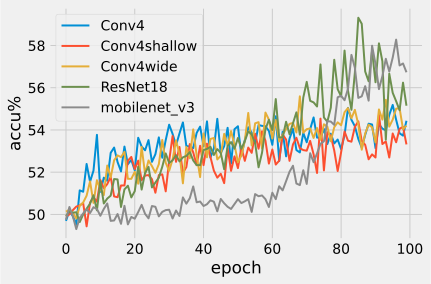

In [11]:
avg_accu_list = []
for key, value in model_dict.items():
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    print('torch.cuda.memory_allocated:', torch.cuda.memory_allocated())
    # Relational Reasoning part
    backbone = value[0]
    backbone.to(device)
    model = RelationalReasoning(backbone, value[1])      
    model.train(tot_epochs=tot_epochs, train_loader=train_loader)
    torch.save(model.backbone.state_dict(), key + '.tar')
    # Testing part
    linear_layer = torch.nn.Linear(value[1], 2)
    backbone_lineval = value[0]
    checkpoint = torch.load(key + '.tar')
    backbone_lineval.load_state_dict(checkpoint)
    
    optimizer = torch.optim.Adam(linear_layer.parameters())                               
    CE = torch.nn.CrossEntropyLoss()
    linear_layer.to(device)
    linear_layer.train()
    backbone_lineval.to(device)
    backbone_lineval.eval()
    
    accuracy_list = []
    with torch.no_grad():
        for test_loader in test_loaders:
            for i, (data, target) in enumerate(test_loader[0]):
                data = data.to(device)
                target = target.to(device)
                output = backbone_lineval(data).detach()
                output = linear_layer(output)
                prediction = output.argmax(-1)
                correct = prediction.eq(target.view_as(prediction)).sum()
                accuracy = (100.0 * correct / len(target))
                accuracy_list.append(accuracy.item())
            avg_accu = sum(accuracy_list)/len(accuracy_list)
            avg_accu_list.append(avg_accu)
            print('Test accuracy', test_loader[1], ': {:.2f}%'.format(avg_accu))
    
    gc.collect()
    torch.cuda.empty_cache()


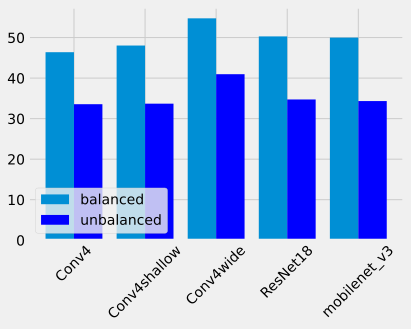

In [12]:
team = ['Conv4', 'Conv4shallow', 'Conv4wide', 'ResNet18','mobilenet_v3']
avg_balanced = avg_accu_list[::2]
avg_unbalanced = avg_accu_list[1::2]

x_axis = np.arange(len(team))

fig, ax = plt.subplots()
plt.bar(x_axis -0.2, avg_balanced, width=0.4, label = 'balanced')
plt.bar(x_axis +0.2, avg_unbalanced, width=0.4, color='b', label = 'unbalanced')

plt.xticks(x_axis, team, rotation=45)
plt.legend(loc="lower left")
plt.show()